In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns

def unwrap_CPUs(df):
    new_df = df.copy()
    for i in range(16):
        col_name = "CPU{}".format(i)
        new_df[col_name] = df["CPU"].apply(lambda x: x[i])
    return new_df

In [86]:
# Read data from files
gazebo_static = pd.read_csv("data/Gazebo/static_test.csv")
gazebo_static_fps = pd.read_csv("data/Gazebo/static_gazebo_fps.csv")
gazebo_dynamic = pd.read_csv("data/Gazebo/dynamic_test.csv")
gazebo_dynamic_fps = pd.read_csv("data/Gazebo/dynamic_gazebo_fps.csv")

# Drop first entry for every experiment (incorrect RTF)
gazebo_static = gazebo_static.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)
gazebo_dynamic = gazebo_dynamic.groupby("count").apply(lambda group: group.iloc[1:]).reset_index(drop=True)

# Convert CPU readings to lists of floats
gazebo_static["CPU"] = gazebo_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
gazebo_dynamic["CPU"] = gazebo_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
gazebo_static["CPU_ALL"] = gazebo_static["CPU"].apply(lambda x: np.mean(x))
gazebo_dynamic["CPU_ALL"] = gazebo_dynamic["CPU"].apply(lambda x: np.mean(x))

# Duplicate data for static scene in dynamic tests
tmp_rows = gazebo_static[gazebo_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
gazebo_dynamic = pd.concat([tmp_rows, gazebo_dynamic], axis=0).reset_index(drop=True)

# Create average of all readings where possible
gazebo_static_tmp = gazebo_static.groupby(["test", "count"]).agg("mean").reset_index()
gazebo_dynamic_tmp = gazebo_dynamic.groupby(["test", "count"]).agg("mean").reset_index()

gazebo_static_tmp["FPS"] = gazebo_static_fps["FPS"]
gazebo_static_tmp["CPU"] = gazebo_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_static = gazebo_static_tmp

gazebo_dynamic_tmp["FPS"] = gazebo_dynamic_fps["FPS"]
gazebo_dynamic_tmp["CPU"] = gazebo_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_dynamic = gazebo_dynamic_tmp

gazebo_tests = pd.concat([gazebo_static, gazebo_dynamic])
gazebo_tests["RAM_USED"] = gazebo_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)
gazebo_tests["FPS_SCALED"] = gazebo_tests["FPS"]*gazebo_tests["RTF"]

# Final dataframes
gazebo_static = gazebo_tests[gazebo_tests["test"] == "static"]
gazebo_dynamic = gazebo_tests[gazebo_tests["test"] == "dynamic"]

# Unwrap CPU list to separate columns
gazebo_static = unwrap_CPUs(gazebo_static)
gazebo_dynamic = unwrap_CPUs(gazebo_dynamic)

In [87]:
# Read data from files
unity_static = pd.read_csv("data/Unity/static_test.csv")
unity_static_fps = pd.read_csv("data/Unity/static_unity_linux_fps.csv")
unity_dynamic = pd.read_csv("data/Unity/dynamic_test.csv")
unity_dynamic_fps = pd.read_csv("data/Unity/dynamic_unity_linux_fps.csv")
unity_dynamic_slowed = pd.read_csv("data/Unity/dynamic_test_slowed.csv")
unity_dynamic_slowed_fps = pd.read_csv("data/Unity/dynamic_slowed_unity_linux_fps.csv")

# Convert CPU readings to lists of floats
unity_static["CPU"] = unity_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_dynamic["CPU"] = unity_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_dynamic_slowed["CPU"] = unity_dynamic_slowed["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
unity_static["CPU_ALL"] = unity_static["CPU"].apply(lambda x: np.mean(x))
unity_dynamic["CPU_ALL"] = unity_dynamic["CPU"].apply(lambda x: np.mean(x))
unity_dynamic_slowed["CPU_ALL"] = unity_dynamic_slowed["CPU"].apply(lambda x: np.mean(x))

# Duplicate data for static scene in dynamic tests
tmp_rows = unity_static[unity_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
unity_dynamic = pd.concat([tmp_rows, unity_dynamic], axis=0).reset_index(drop=True)
unity_dynamic_slowed = pd.concat([tmp_rows.copy(), unity_dynamic_slowed], axis=0).reset_index(drop=True)
unity_dynamic_slowed["test"] = "dynamic_slowed"

# Create average of all readings where possible
unity_static_tmp = unity_static.groupby(["test", "count"]).agg("mean").reset_index()
unity_dynamic_tmp = unity_dynamic.groupby(["test", "count"]).agg("mean").reset_index()
unity_dynamic_slowed_tmp = unity_dynamic_slowed.groupby(["test", "count"]).agg("mean").reset_index()

unity_static_tmp["FPS"] = unity_static_fps["FPS"]
unity_static_tmp["CPU"] = unity_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_static = unity_static_tmp

unity_dynamic_tmp["FPS"] = unity_dynamic_fps["FPS"]
unity_dynamic_tmp["CPU"] = unity_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_dynamic = unity_dynamic_tmp

unity_dynamic_slowed_tmp["FPS"] = unity_dynamic_slowed_fps["FPS"]
unity_dynamic_slowed_tmp["CPU"] = unity_dynamic_slowed[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_dynamic_slowed = unity_dynamic_slowed_tmp

unity_tests = pd.concat([unity_static, unity_dynamic, unity_dynamic_slowed])
unity_tests["RAM_USED"] = unity_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)

# Final dataframes
unity_static = unity_tests[unity_tests["test"] == "static"]
unity_dynamic = unity_tests[unity_tests["test"] == "dynamic"]
unity_dynamic_slowed = unity_tests[unity_tests["test"] == "dynamic_slowed"]

# Unwrap CPU list to separate columns
unity_static = unwrap_CPUs(unity_static)
unity_dynamic = unwrap_CPUs(unity_dynamic)
unity_dynamic_slowed = unwrap_CPUs(unity_dynamic_slowed)

unity_dynamic_slowed["FPS"] = unity_dynamic_slowed["FPS"] * gazebo_dynamic["RTF"]  # Becuase the FPS counter was measuring incorrect data

In [88]:
# Read data from files
unity_win_static = pd.read_csv("data/Unity Windows/static_test.csv")
unity_win_static_fps = pd.read_csv("data/Unity Windows/static_unity_windows_fps.csv")
unity_win_dynamic = pd.read_csv("data/Unity Windows/dynamic_test.csv")
unity_win_dynamic_fps = pd.read_csv("data/Unity Windows/dynamic_unity_windows_fps.csv")
unity_win_dynamic_slowed = pd.read_csv("data/Unity Windows/dynamic_test_slowed.csv")
unity_win_dynamic_slowed_fps = pd.read_csv("data/Unity Windows/dynamic_slowed_unity_windows_fps.csv")

# Convert CPU readings to lists of floats
unity_win_static["CPU"] = unity_win_static["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_win_dynamic["CPU"] = unity_win_dynamic["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_win_dynamic_slowed["CPU"] = unity_win_dynamic_slowed["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
unity_win_static["CPU_ALL"] = unity_win_static["CPU"].apply(lambda x: np.mean(x))
unity_win_dynamic["CPU_ALL"] = unity_win_dynamic["CPU"].apply(lambda x: np.mean(x))
unity_win_dynamic_slowed["CPU_ALL"] = unity_win_dynamic_slowed["CPU"].apply(lambda x: np.mean(x))

# # Duplicate data for static scene in dynamic tests
tmp_rows = unity_win_static[unity_win_static["count"] == 0].copy()
tmp_rows["test"] = "dynamic"
unity_win_dynamic = pd.concat([tmp_rows, unity_win_dynamic], axis=0).reset_index(drop=True)
unity_win_dynamic_slowed = pd.concat([tmp_rows.copy(), unity_win_dynamic_slowed], axis=0).reset_index(drop=True)
unity_win_dynamic_slowed["test"] = "dynamic_slowed"

# Create average of all readings where possible
unity_win_static_tmp = unity_win_static.groupby(["test", "count"]).agg("mean").reset_index()
unity_win_dynamic_tmp = unity_win_dynamic.groupby(["test", "count"]).agg("mean").reset_index()
unity_win_dynamic_slowed_tmp = unity_win_dynamic_slowed.groupby(["test", "count"]).agg("mean").reset_index()

unity_win_static_tmp["FPS"] = unity_win_static_fps["FPS"]
unity_win_static_tmp["CPU"] = unity_win_static[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_static = unity_win_static_tmp

unity_win_dynamic_tmp["FPS"] = unity_win_dynamic_fps["FPS"]
unity_win_dynamic_tmp["CPU"] = unity_win_dynamic[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_dynamic = unity_win_dynamic_tmp

unity_win_dynamic_slowed_fps.iloc[0,1] = unity_win_static_fps.iloc[0,1]
unity_win_dynamic_slowed_fps = unity_win_dynamic_slowed_fps.dropna().reset_index()
unity_win_dynamic_slowed_tmp["FPS"] = unity_win_dynamic_slowed_fps["FPS"]
unity_win_dynamic_slowed_tmp["CPU"] = unity_win_dynamic_slowed[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_dynamic_slowed = unity_win_dynamic_slowed_tmp

unity_win_tests = pd.concat([unity_win_static, unity_win_dynamic, unity_win_dynamic_slowed])
unity_win_tests["RAM_USED"] = unity_win_tests["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)

# Final dataframes
unity_win_static = unity_win_tests[unity_win_tests["test"] == "static"]
unity_win_dynamic = unity_win_tests[unity_win_tests["test"] == "dynamic"]
unity_win_dynamic_slowed = unity_win_tests[unity_win_tests["test"] == "dynamic_slowed"]

# Unwrap CPU list to separate columns
unity_win_static = unwrap_CPUs(unity_win_static)
unity_win_dynamic = unwrap_CPUs(unity_win_dynamic)
unity_win_dynamic_slowed = unwrap_CPUs(unity_win_dynamic_slowed)

In [89]:
# Read data from files
unity_win_dynamic_vulkan = pd.read_csv("data/Unity Windows Vulkan/dynamic_test_vulkan.csv")
unity_win_dynamic_vulkan_fps = pd.read_csv("data/Unity Windows Vulkan/dynamic-vulkan-windows-fps.csv")

# Convert CPU readings to lists of floats
unity_win_dynamic_vulkan["CPU"] = unity_win_dynamic_vulkan["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
unity_win_dynamic_vulkan["CPU_ALL"] = unity_win_dynamic_vulkan["CPU"].apply(lambda x: np.mean(x))

# # Duplicate data for static scene in dynamic tests
tmp_rows["test"] = "dynamic-vulcan"
unity_win_dynamic_vulkan = pd.concat([tmp_rows.copy(), unity_win_dynamic_vulkan], axis=0).reset_index(drop=True)

# Create average of all readings where possible
unity_win_dynamic_vulkan_tmp = unity_win_dynamic_vulkan.groupby(["test", "count"]).agg("mean").reset_index()

unity_win_dynamic_vulkan_fps.iloc[0,1] = unity_win_static_fps.iloc[0,1]
unity_win_dynamic_vulkan_fps = unity_win_dynamic_vulkan_fps.dropna().reset_index()
unity_win_dynamic_vulkan_tmp["FPS"] = unity_win_dynamic_vulkan_fps["FPS"]
unity_win_dynamic_vulkan_tmp["CPU"] = unity_win_dynamic_vulkan[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_dynamic_vulkan = unity_win_dynamic_vulkan_tmp

unity_win_dynamic_vulkan["RAM_USED"] = unity_win_dynamic_vulkan["RAM_USED"] / (1024**3)  # Bytes to GiB (Gibibytes)

# Unwrap CPU list to separate columns
unity_win_dynamic_vulkan = unwrap_CPUs(unity_win_dynamic_vulkan)

In [90]:
# Read data from files
gazebo_robot = pd.read_csv("data/Gazebo/multi_robot.csv")
gazebo_robot_fps = pd.read_csv("data/Gazebo/multi_robot_linux_fps.csv")
unity_robot = pd.read_csv("data/Unity/multi_robot.csv")
unity_robot_fps = pd.read_csv("data/Unity/multi_robot_unity_linux_fps.csv")
unity_win_robot = pd.read_csv("data/Unity Windows/multi_robot.csv")
unity_win_robot_fps = pd.read_csv("data/Unity Windows/multi-robot-windows-fps.csv")


# Convert CPU readings to lists of floats
gazebo_robot["CPU"] = gazebo_robot["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_robot["CPU"] = unity_robot["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))
unity_win_robot["CPU"] = unity_win_robot["CPU"].apply(lambda x: sorted([float(i) for i in x[1:-1].split(',')], reverse=True))

# Create CPU performance aggregate
gazebo_robot["CPU_ALL"] = gazebo_robot["CPU"].apply(lambda x: np.mean(x))
unity_robot["CPU_ALL"] = unity_robot["CPU"].apply(lambda x: np.mean(x))
unity_win_robot["CPU_ALL"] = unity_win_robot["CPU"].apply(lambda x: np.mean(x))

# Create average of all readings where possible
gazebo_robot_tmp = gazebo_robot.groupby(["test", "count"]).agg("mean").reset_index()
unity_robot_tmp = unity_robot.groupby(["test", "count"]).agg("mean").reset_index()
unity_win_robot_tmp = unity_win_robot.groupby(["test", "count"]).agg("mean").reset_index()

gazebo_robot_tmp["FPS"] = gazebo_robot_fps["FPS"]
gazebo_robot_tmp["CPU"] = gazebo_robot[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
gazebo_robot = gazebo_robot_tmp

unity_robot_tmp["FPS"] = unity_robot_fps["FPS"]
unity_robot_tmp["CPU"] = unity_robot[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_robot = unity_robot_tmp

unity_win_robot_tmp["FPS"] = unity_win_robot_fps["FPS"]
unity_win_robot_tmp["CPU"] = unity_win_robot[["count", "CPU"]].groupby("count").agg({"CPU": lambda x: [np.mean(i) for i in zip(*x)]}).reset_index()["CPU"]
unity_win_robot = unity_win_robot_tmp

# Bytes to GiB (Gibibytes)
gazebo_robot["RAM_USED"] = gazebo_robot["RAM_USED"] / (1024**3) 
unity_robot["RAM_USED"] = unity_robot["RAM_USED"] / (1024**3) 
unity_win_robot["RAM_USED"] = unity_win_robot["RAM_USED"] / (1024**3) 

# Unwrap CPU list to separate columns
gazebo_robot = unwrap_CPUs(gazebo_robot)
unity_robot = unwrap_CPUs(unity_robot)
unity_win_robot = unwrap_CPUs(unity_win_robot)

---------------------------------------------------------------

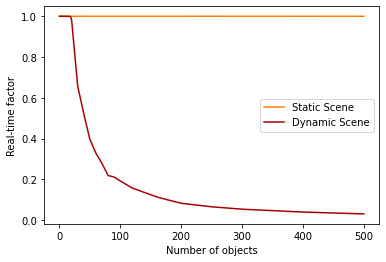

In [91]:
fig, ax = plt.subplots()
plt.plot(gazebo_static["count"], gazebo_static["RTF"], "#ff7f00", label="Static Scene")
plt.plot(gazebo_dynamic["count"], gazebo_dynamic["RTF"], "#ab0000", label="Dynamic Scene")
plt.legend()
plt.ylabel("Real-time factor")
plt.xlabel("Number of objects")

plt.savefig("exported_graphs/RTF_gazebo.png", dpi=500)
plt.show()

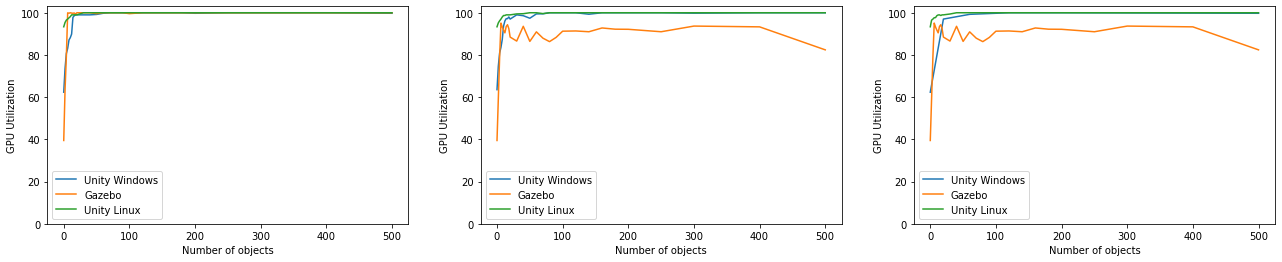

In [92]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["GPU"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["GPU"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["GPU"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["GPU"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["GPU"], label="Unity Linux")
# ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["GPU"], label="Unity Windows Vulkan")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("GPU Utilization")
    i.set_ylim(0)
    i.legend()
         
plt.show()

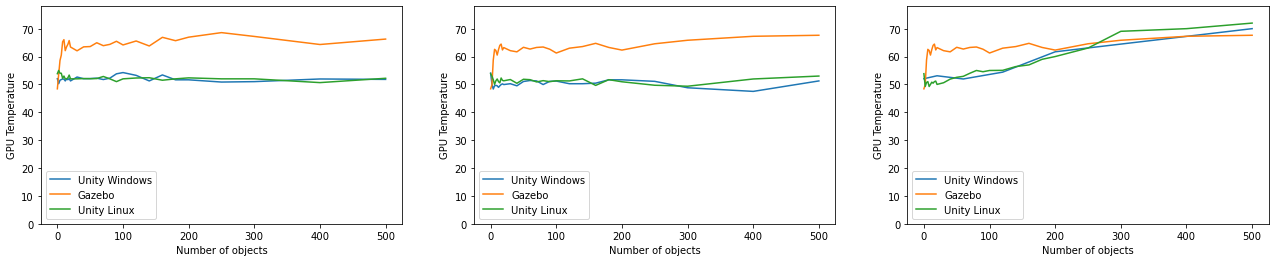

In [93]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["GPU_TEMP"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["GPU_TEMP"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["GPU_TEMP"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["GPU_TEMP"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["GPU_TEMP"], label="Unity Linux")
# ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["GPU_TEMP"], label="Unity Windows Vulkan")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU_TEMP"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU_TEMP"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("GPU Temperature")
    i.set_ylim(0,78)
    i.legend()
         
plt.show()

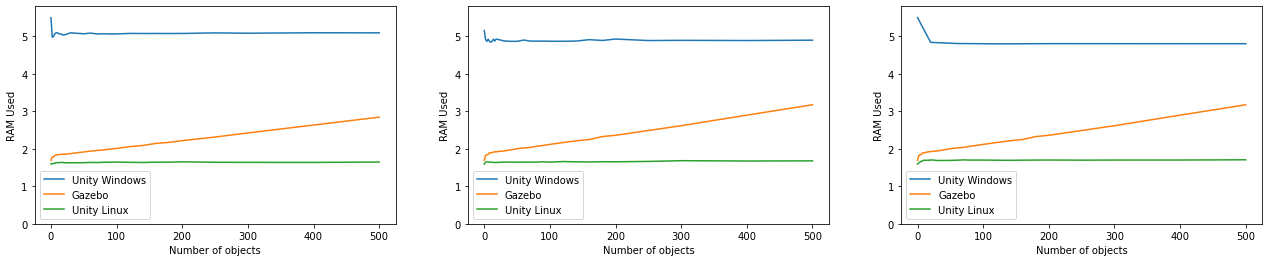

In [94]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["RAM_USED"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["RAM_USED"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["RAM_USED"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["RAM_USED"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["RAM_USED"], label="Unity Linux")
# ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["RAM_USED"], label="Unity Windows Vulkan")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["RAM_USED"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["RAM_USED"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("RAM Used")
    i.set_ylim(0,5.8)
    i.legend()
         
plt.show()

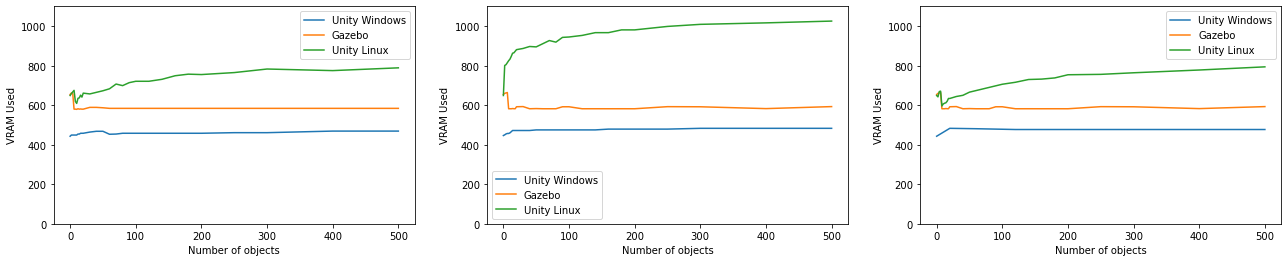

In [95]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["VRAM_USED"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["VRAM_USED"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["VRAM_USED"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["VRAM_USED"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["VRAM_USED"], label="Unity Linux")
# ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["VRAM_USED"], label="Unity Windows Vulkan")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["VRAM_USED"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["VRAM_USED"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("VRAM Used")
    i.set_ylim(0, 1100)
    i.legend()
         
plt.show()

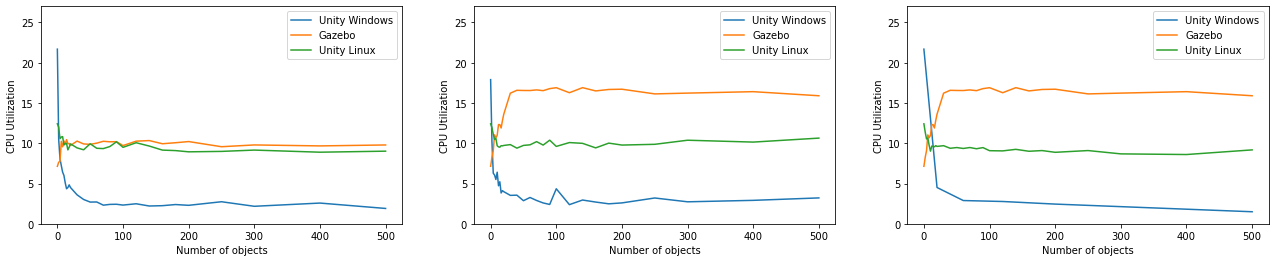

In [96]:
fig, ax = plt.subplots(1,3, figsize=(22, 4))

ax[0].plot(unity_win_static["count"], unity_win_static["CPU_ALL"], label="Unity Windows")
ax[0].plot(gazebo_static["count"], gazebo_static["CPU_ALL"], label="Gazebo")
ax[0].plot(unity_static["count"], unity_static["CPU_ALL"], label="Unity Linux")

ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic["CPU_ALL"], label="Unity Windows")
ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], label="Gazebo")
ax[1].plot(unity_dynamic["count"], unity_dynamic["CPU_ALL"], label="Unity Linux")
# ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["CPU_ALL"], label="Unity Windows Vulkan")

ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["CPU_ALL"], label="Unity Windows")
ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], label="Gazebo")
ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["CPU_ALL"], label="Unity Linux")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("CPU Utilization")
    i.set_ylim(0,27)
    i.legend()
         
plt.show()

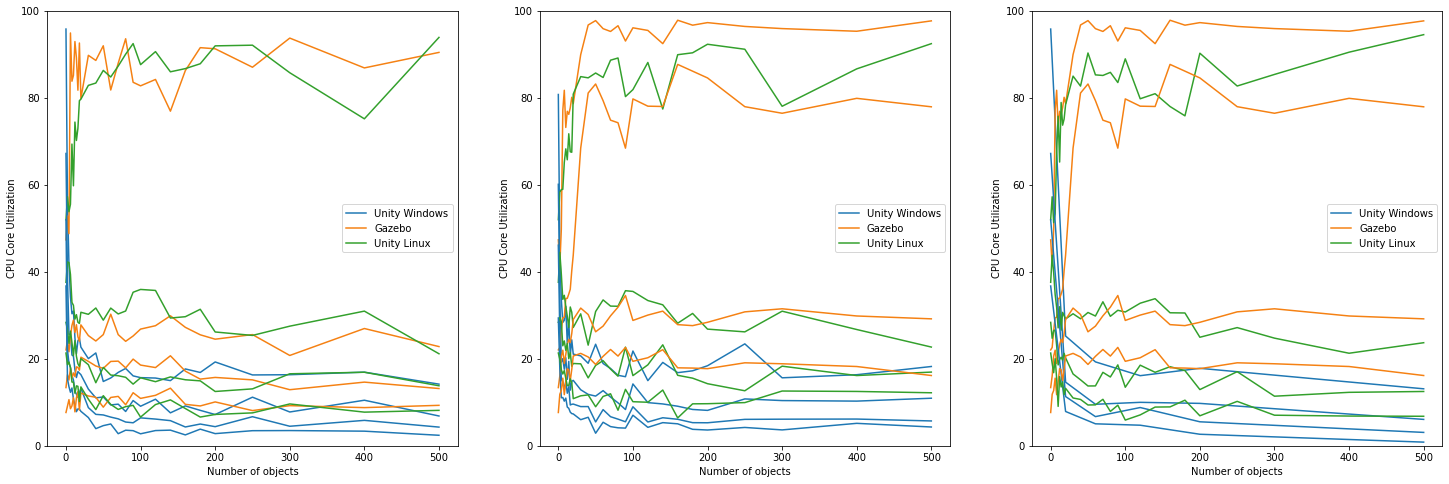

In [97]:
fig, ax = plt.subplots(1,3, figsize=(25, 8))

# First 4 cores
for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax[0].plot(unity_win_static["count"], unity_win_static[col_name], '#1f78b4')
    ax[0].plot(gazebo_static["count"], gazebo_static[col_name], '#f58113')
    ax[0].plot(unity_static["count"], unity_static[col_name], "#33a02c")

    ax[1].plot(unity_win_dynamic["count"], unity_win_dynamic[col_name], '#1f78b4')
    ax[1].plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], '#f58113')
    ax[1].plot(unity_dynamic["count"], unity_dynamic[col_name], "#33a02c")
    # ax[1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan[col_name], '#ab0000')

    ax[2].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed[col_name], '#1f78b4')
    ax[2].plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], '#f58113')
    ax[2].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed[col_name], "#33a02c")

for i in ax:
    i.set_xlabel("Number of objects")
    i.set_ylabel("CPU Core Utilization")
    i.set_ylim(0,100)
    i.legend(["Unity Windows", "Gazebo", "Unity Linux"])
         
plt.show()

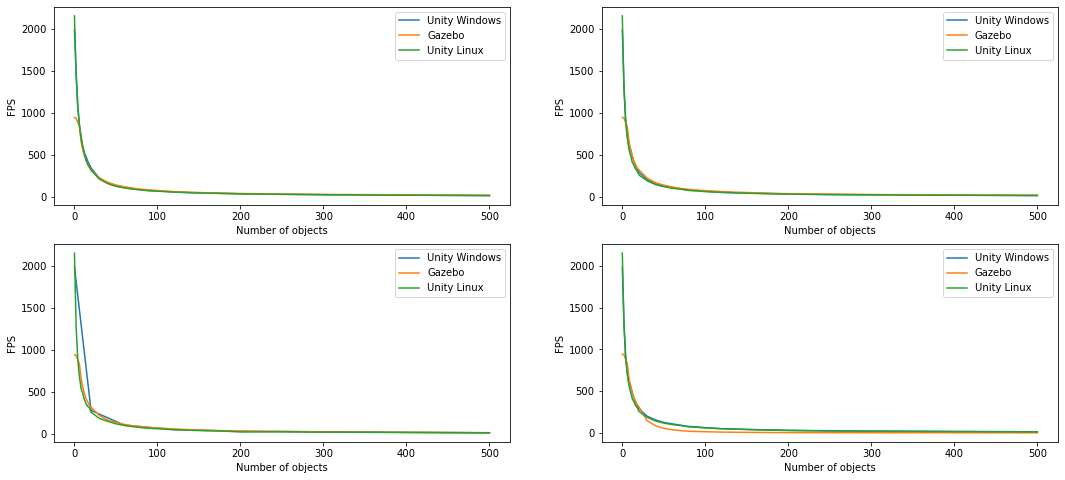

In [98]:
fig, ax = plt.subplots(2,2, figsize=(18, 8))

ax[0,0].plot(unity_win_static["count"], unity_win_static["FPS"], label="Unity Windows")
ax[0,0].plot(gazebo_static["count"], gazebo_static["FPS"], label="Gazebo")
ax[0,0].plot(unity_static["count"], unity_static["FPS"], label="Unity Linux")

ax[0,1].plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], label="Unity Windows")
ax[0,1].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], label="Gazebo")
ax[0,1].plot(unity_dynamic["count"], unity_dynamic["FPS"], label="Unity Linux")
# ax[0,1].plot(unity_win_dynamic_vulkan["count"], unity_win_dynamic_vulkan["FPS"], label="Unity Windows Vulkan")

ax[1,0].plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["FPS"], label="Unity Windows")
ax[1,0].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], label="Gazebo")
ax[1,0].plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["FPS"], label="Unity Linux")

ax[1,1].plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], label="Unity Windows")
ax[1,1].plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_SCALED"], label="Gazebo")
ax[1,1].plot(unity_dynamic["count"], unity_dynamic["FPS"], label="Unity Linux")

for i in ax.flatten():
    i.set_xlabel("Number of objects")
    i.set_ylabel("FPS")
    # i.set_ylim(-5, 30)
    # i.set_xlim(50, 550)
    i.legend()
         
plt.show()

## 

------------------------------

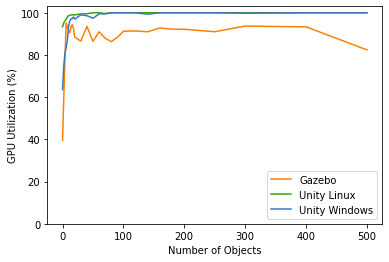

In [99]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_GPU.png", dpi=500)
plt.show()

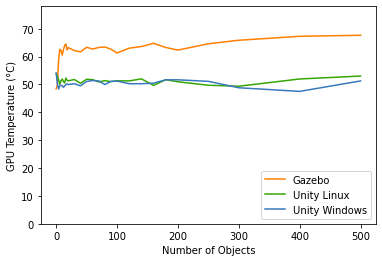

In [100]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU_TEMP"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_GPU_temp.png", dpi=500)
plt.show()

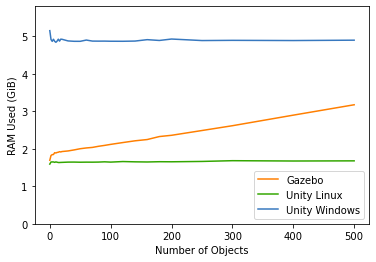

In [101]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["RAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0, 5.8)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_RAM.png", dpi=500)
plt.show()

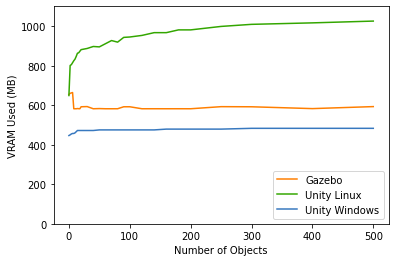

In [102]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["VRAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_VRAM.png", dpi=500)
plt.show()

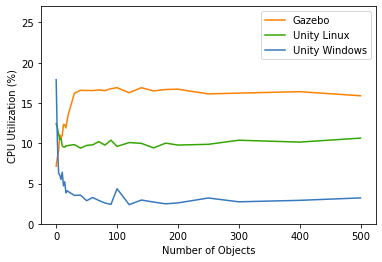

In [103]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["CPU_ALL"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_CPU.png", dpi=500)
plt.show()

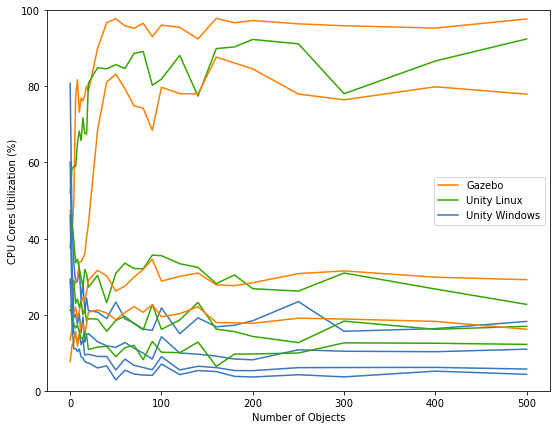

In [104]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], "#ff7f00")
    ax.plot(unity_dynamic["count"], unity_dynamic[col_name], "#33a600")
    ax.plot(unity_win_dynamic["count"], unity_win_dynamic[col_name], "#3778bf")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

gz_patch = Line2D([0],[0],color='#ff7f00', label='Gazebo')
lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')

plt.legend(handles=[gz_patch,lin_patch,win_patch])

plt.savefig("exported_graphs/dynamic_CPU_cores.png", dpi=500)
plt.show()

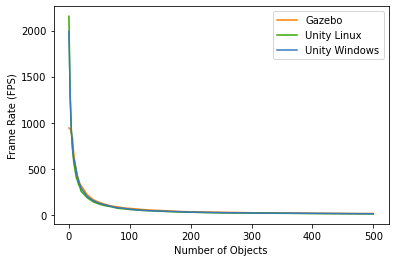

In [105]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_FPS.png", dpi=500)
plt.show()

In [106]:
gazebo_dynamic["FPS_diff"] = gazebo_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_dynamic["FPS_diff"] = unity_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_win_dynamic["FPS_diff"] = unity_win_dynamic["FPS"] - gazebo_dynamic["FPS"]

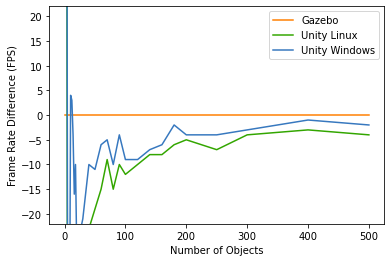

In [107]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS_diff"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate Difference (FPS)")
plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_FPS_diff.png", dpi=500)
plt.show()

----

------------------------------

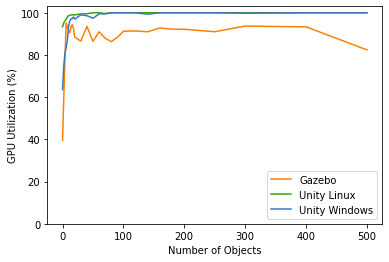

In [108]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_GPU.png", dpi=500)
plt.show()

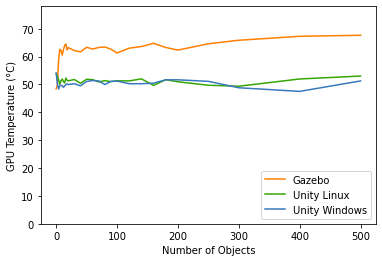

In [109]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU_TEMP"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_GPU_temp.png", dpi=500)
plt.show()

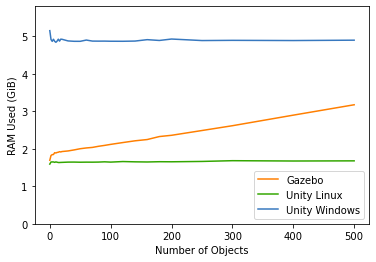

In [110]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["RAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0, 5.8)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_RAM.png", dpi=500)
plt.show()

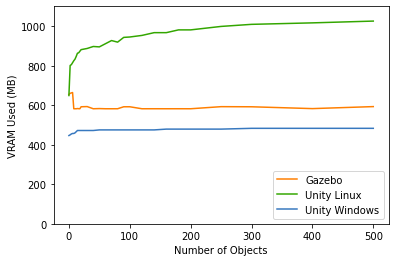

In [111]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["VRAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_VRAM.png", dpi=500)
plt.show()

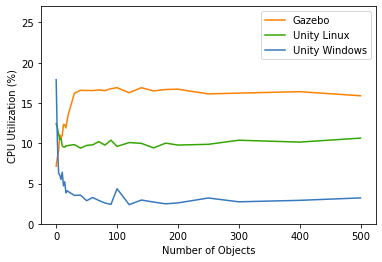

In [112]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["CPU_ALL"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_CPU.png", dpi=500)
plt.show()

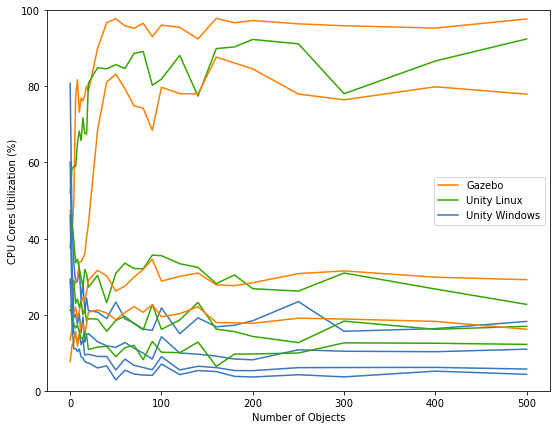

In [113]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], "#ff7f00")
    ax.plot(unity_dynamic["count"], unity_dynamic[col_name], "#33a600")
    ax.plot(unity_win_dynamic["count"], unity_win_dynamic[col_name], "#3778bf")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

gz_patch = Line2D([0],[0],color='#ff7f00', label='Gazebo')
lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')

plt.legend(handles=[gz_patch,lin_patch,win_patch])

plt.savefig("exported_graphs/dynamic_CPU_cores.png", dpi=500)
plt.show()

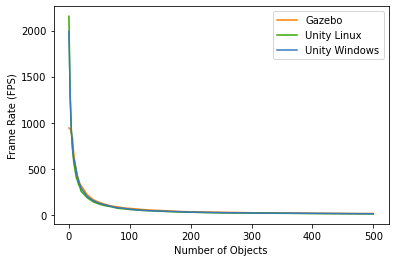

In [114]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_FPS.png", dpi=500)
plt.show()

In [115]:
gazebo_dynamic["FPS_diff"] = gazebo_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_dynamic["FPS_diff"] = unity_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_win_dynamic["FPS_diff"] = unity_win_dynamic["FPS"] - gazebo_dynamic["FPS"]

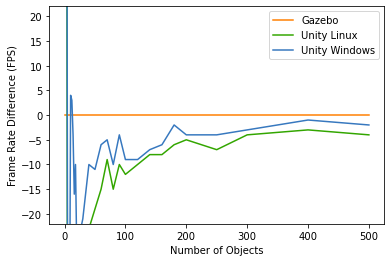

In [116]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS_diff"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate Difference (FPS)")
plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_FPS_diff.png", dpi=500)
plt.show()

----

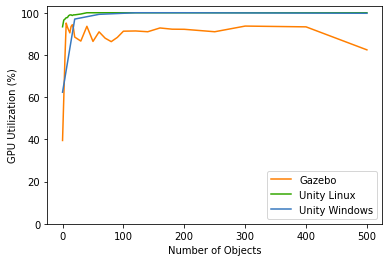

In [117]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_slowed_GPU.png", dpi=500)
plt.show()

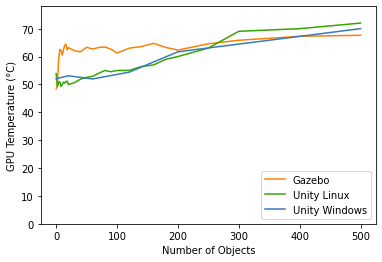

In [118]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["GPU_TEMP"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU_TEMP"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_slowed_GPU_temp.png", dpi=500)
plt.show()

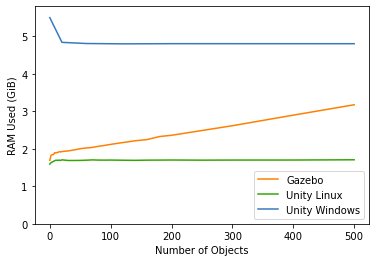

In [119]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["RAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["RAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0, 5.8)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_slowed_RAM.png", dpi=500)
plt.show()

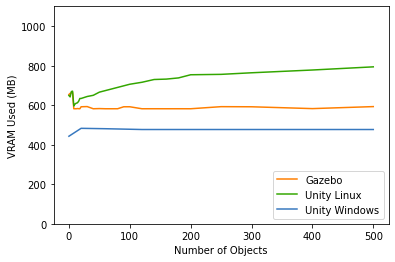

In [120]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["VRAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["VRAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_slowed_VRAM.png", dpi=500)
plt.show()

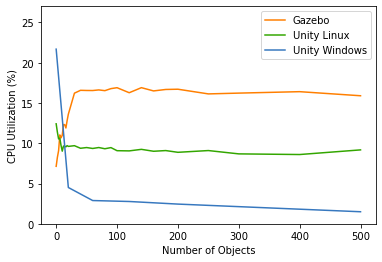

In [121]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["CPU_ALL"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["CPU_ALL"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_slowed_CPU.png", dpi=500)
plt.show()

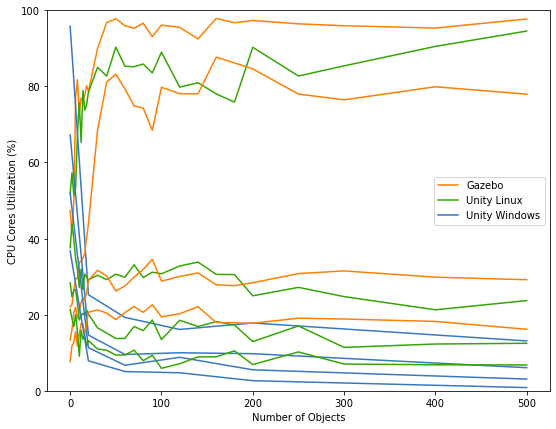

In [122]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(gazebo_dynamic["count"], gazebo_dynamic[col_name], "#ff7f00")
    ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed[col_name], "#33a600")
    ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed[col_name], "#3778bf")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

gz_patch = Line2D([0],[0],color='#ff7f00', label='Gazebo')
lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')

plt.legend(handles=[gz_patch,lin_patch,win_patch])

plt.savefig("exported_graphs/dynamic_slowed_CPU_cores.png", dpi=500)
plt.show()

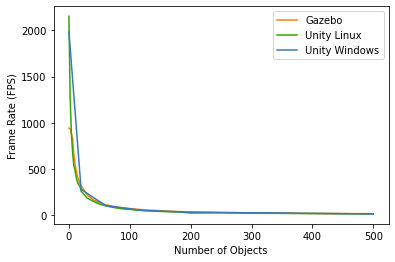

In [123]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_slowed_FPS.png", dpi=500)
plt.show()

In [124]:
gazebo_dynamic["FPS_diff"] = gazebo_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_dynamic_slowed["FPS_diff"] = unity_dynamic_slowed["FPS"] - gazebo_dynamic["FPS"]
unity_win_dynamic_slowed["FPS_diff"] = unity_win_dynamic_slowed["FPS"] - gazebo_dynamic["FPS"]

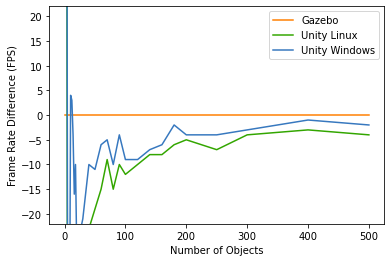

In [125]:
fig, ax = plt.subplots()

ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS_diff"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate Difference (FPS)")
plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_slowed_FPS_diff.png", dpi=500)
plt.show()

----

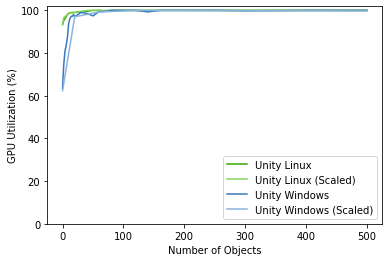

In [126]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_unity_GPU.png", dpi=500)
plt.show()

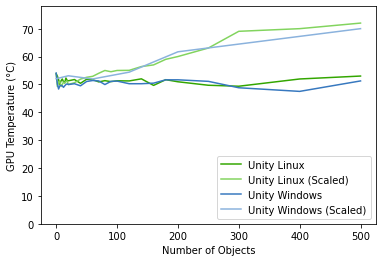

In [127]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["GPU_TEMP"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["GPU_TEMP"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["GPU_TEMP"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_unity_GPU_temp.png", dpi=500)
plt.show()

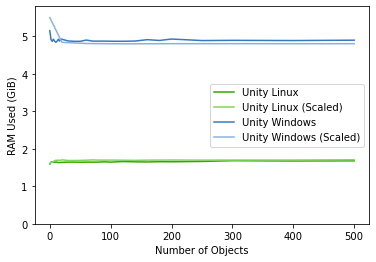

In [128]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["RAM_USED"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["RAM_USED"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["RAM_USED"], "#8AB2DD", label="Unity Windows (Scaled)")


plt.xlabel("Number of Objects")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0, 5.8)
plt.legend()

plt.savefig("exported_graphs/dynamic_unity_RAM.png", dpi=500)
plt.show()

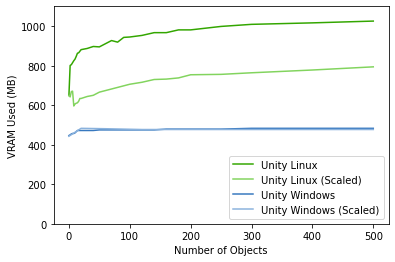

In [129]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["VRAM_USED"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["VRAM_USED"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["VRAM_USED"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/dynamic_unity_VRAM.png", dpi=500)
plt.show()

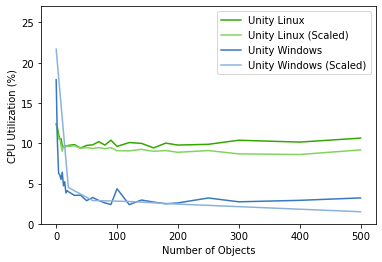

In [130]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["CPU_ALL"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["CPU_ALL"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["CPU_ALL"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_unity_CPU.png", dpi=500)
plt.show()

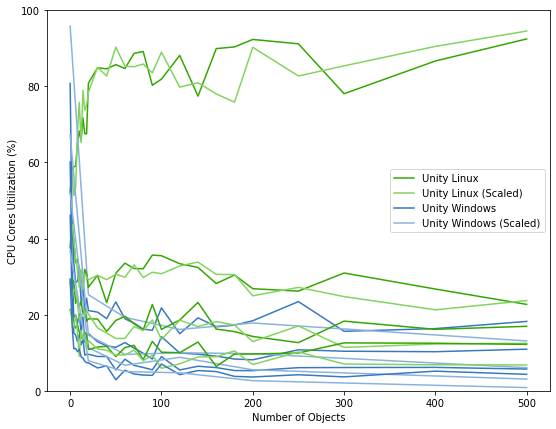

In [131]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(unity_dynamic["count"], unity_dynamic[col_name], "#33a600", label="Unity Linux")
    ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed[col_name], "#82d45e", label="Unity Linux (Scaled)")
    ax.plot(unity_win_dynamic["count"], unity_win_dynamic[col_name], "#3778bf", label="Unity Windows")
    ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed[col_name], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
slin_patch = Line2D([0],[0],color='#82d45e', label='Unity Linux (Scaled)')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')
swin_patch = Line2D([0],[0],color='#8AB2DD', label='Unity Windows (Scaled)')

plt.legend(handles=[lin_patch,slin_patch,win_patch, swin_patch])

plt.savefig("exported_graphs/dynamic_unity_CPU_cores.png", dpi=500)
plt.show()

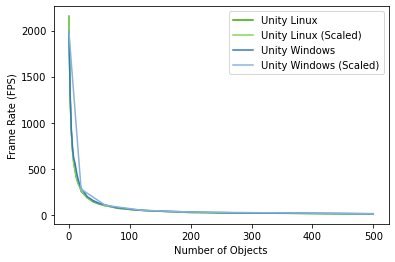

In [132]:
fig, ax = plt.subplots()

ax.plot(unity_dynamic["count"], unity_dynamic["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["FPS"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["FPS"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_unity_FPS.png", dpi=500)
plt.show()

In [133]:
gazebo_dynamic["FPS_diff"] = gazebo_dynamic["FPS"] - gazebo_dynamic["FPS"]
unity_dynamic_slowed["FPS_diff"] = unity_dynamic_slowed["FPS"] - gazebo_dynamic["FPS"]
unity_win_dynamic_slowed["FPS_diff"] = unity_win_dynamic_slowed["FPS"] - gazebo_dynamic["FPS"]

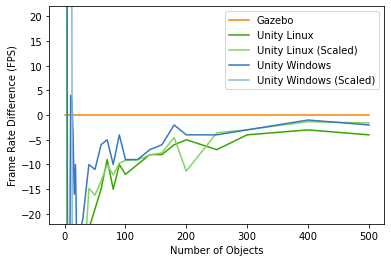

In [134]:
fig, ax = plt.subplots()


ax.plot(gazebo_dynamic["count"], gazebo_dynamic["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_dynamic["count"], unity_dynamic["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_dynamic_slowed["count"], unity_dynamic_slowed["FPS_diff"], "#82d45e", label="Unity Linux (Scaled)")
ax.plot(unity_win_dynamic["count"], unity_win_dynamic["FPS_diff"], "#3778bf", label="Unity Windows")
ax.plot(unity_win_dynamic_slowed["count"], unity_win_dynamic_slowed["FPS_diff"], "#8AB2DD", label="Unity Windows (Scaled)")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate Difference (FPS)")
plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/dynamic_unity_FPS_diff.png", dpi=500)
plt.show()

------------------------------

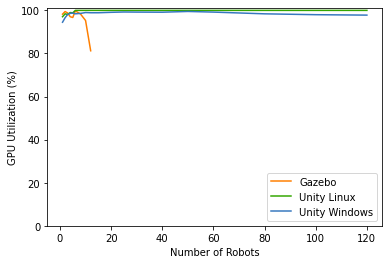

In [135]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["GPU"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["GPU"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/robot_GPU.png", dpi=500)
plt.show()

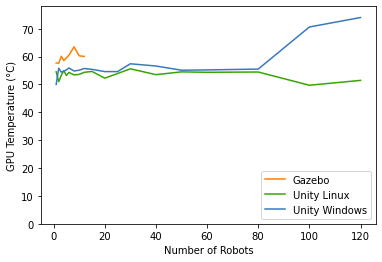

In [136]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["GPU_TEMP"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["GPU_TEMP"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/robot_GPU_temp.png", dpi=500)
plt.show()

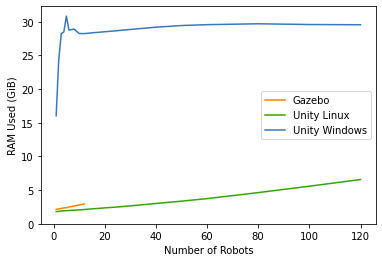

In [137]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["RAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["RAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0)
plt.legend()

plt.savefig("exported_graphs/robot_RAM.png", dpi=500)
plt.show()

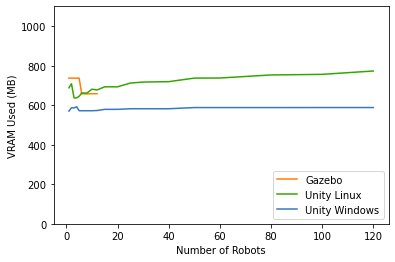

In [138]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["VRAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["VRAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/robot_VRAM.png", dpi=500)
plt.show()

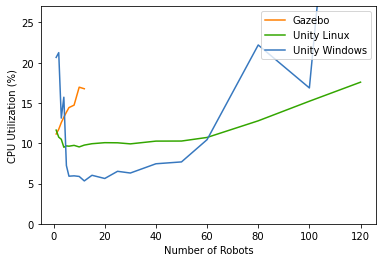

In [139]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["CPU_ALL"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["CPU_ALL"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/robot_CPU.png", dpi=500)
plt.show()

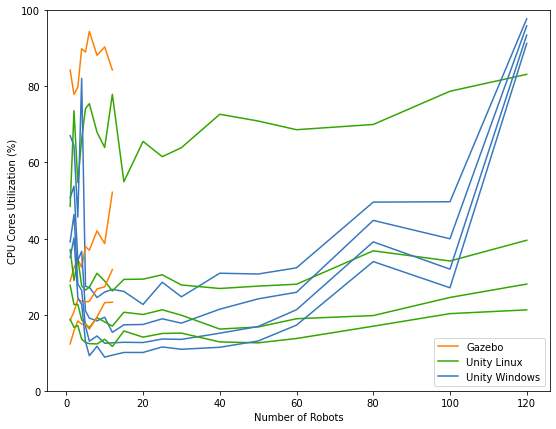

In [140]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(gazebo_robot["count"], gazebo_robot[col_name], "#ff7f00")
    ax.plot(unity_robot["count"], unity_robot[col_name], "#33a600")
    ax.plot(unity_win_robot["count"], unity_win_robot[col_name], "#3778bf")

plt.xlabel("Number of Robots")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

gz_patch = Line2D([0],[0],color='#ff7f00', label='Gazebo')
lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')

plt.legend(handles=[gz_patch,lin_patch,win_patch])

plt.savefig("exported_graphs/robot_CPU_cores.png", dpi=500)
plt.show()

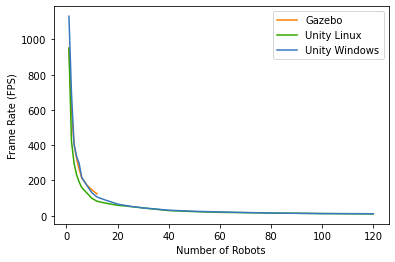

In [141]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/robot_FPS.png", dpi=500)
plt.show()

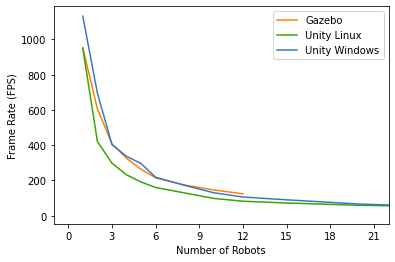

In [142]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("Frame Rate (FPS)")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim(-1,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/robot_FPS_limited.png", dpi=500)
plt.show()

In [143]:
gazebo_robot["FPS_diff"] = gazebo_robot["FPS"] - gazebo_robot["FPS"]
unity_robot["FPS_diff"] = unity_robot["FPS"] - gazebo_robot["FPS"]
unity_win_robot["FPS_diff"] = unity_win_robot["FPS"] - gazebo_robot["FPS"]

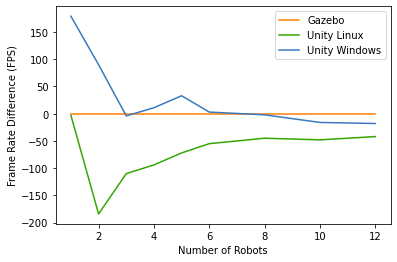

In [144]:
fig, ax = plt.subplots()

ax.plot(gazebo_robot["count"], gazebo_robot["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_robot["count"], unity_robot["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_win_robot["count"], unity_win_robot["FPS_diff"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Robots")
plt.ylabel("Frame Rate Difference (FPS)")
# plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/robot_FPS_diff.png", dpi=500)
plt.show()

----

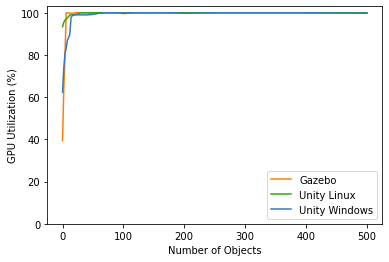

In [145]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["GPU"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["GPU"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["GPU"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Utilization (%)")
plt.ylim(0)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/static_GPU.png", dpi=500)
plt.show()

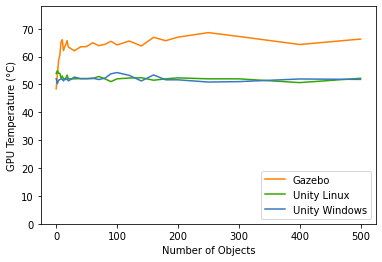

In [146]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["GPU_TEMP"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["GPU_TEMP"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["GPU_TEMP"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("GPU Temperature (°C)")
plt.ylim(0,78)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/static_GPU_temp.png", dpi=500)
plt.show()

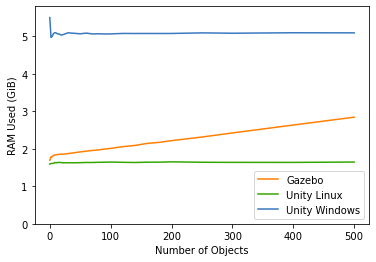

In [147]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["RAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["RAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["RAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("RAM Used (GiB)")
plt.ylim(0, 5.8)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/static_RAM.png", dpi=500)
plt.show()

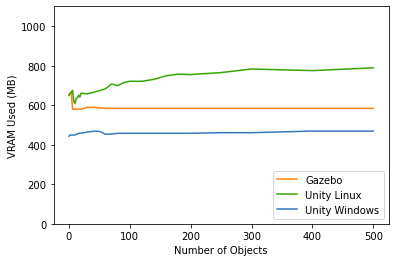

In [148]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["VRAM_USED"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["VRAM_USED"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["VRAM_USED"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("VRAM Used (MB)")
plt.ylim(0,1100)
plt.legend(loc='lower right')

plt.savefig("exported_graphs/static_VRAM.png", dpi=500)
plt.show()

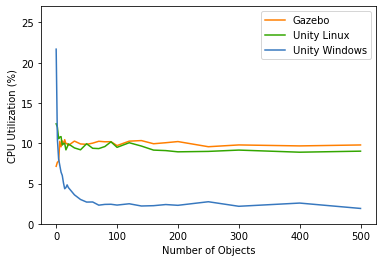

In [149]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["CPU_ALL"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["CPU_ALL"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["CPU_ALL"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Utilization (%)")
plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/static_CPU.png", dpi=500)
plt.show()

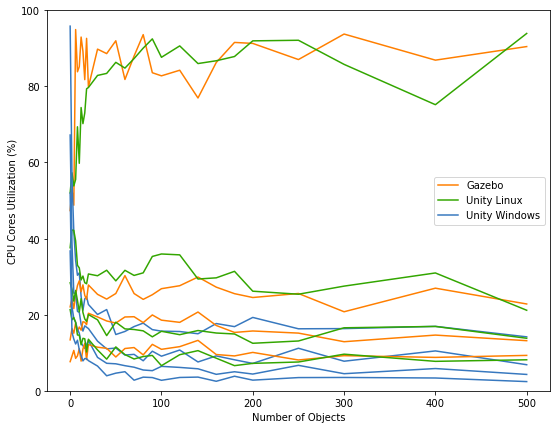

In [150]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in range(4):
    col_name = "CPU{}".format(i)
    
    ax.plot(gazebo_static["count"], gazebo_static[col_name], "#ff7f00")
    ax.plot(unity_static["count"], unity_static[col_name], "#33a600")
    ax.plot(unity_win_static["count"], unity_win_static[col_name], "#3778bf")

plt.xlabel("Number of Objects")
plt.ylabel("CPU Cores Utilization (%)")
plt.ylim(0,100)

gz_patch = Line2D([0],[0],color='#ff7f00', label='Gazebo')
lin_patch = Line2D([0],[0],color='#33a600', label='Unity Linux')
win_patch = Line2D([0],[0],color='#3778bf', label='Unity Windows')

plt.legend(handles=[gz_patch,lin_patch,win_patch])

plt.savefig("exported_graphs/static_CPU_cores.png", dpi=500)
plt.show()

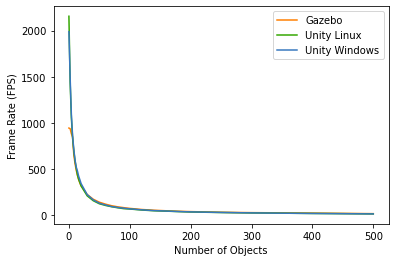

In [151]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["FPS"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["FPS"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["FPS"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate (FPS)")
# plt.ylim(0,27)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/static_FPS.png", dpi=500)
plt.show()

In [152]:
gazebo_static["FPS_diff"] = gazebo_static["FPS"] - gazebo_static["FPS"]
unity_static["FPS_diff"] = unity_static["FPS"] - gazebo_static["FPS"]
unity_win_static["FPS_diff"] = unity_win_static["FPS"] - gazebo_static["FPS"]

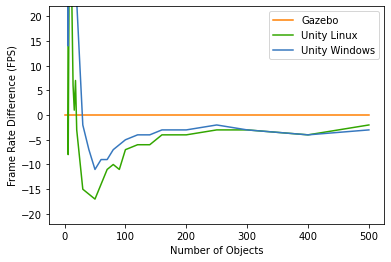

In [153]:
fig, ax = plt.subplots()

ax.plot(gazebo_static["count"], gazebo_static["FPS_diff"], "#ff7f00", label="Gazebo")
ax.plot(unity_static["count"], unity_static["FPS_diff"], "#33a600", label="Unity Linux")
ax.plot(unity_win_static["count"], unity_win_static["FPS_diff"], "#3778bf", label="Unity Windows")

plt.xlabel("Number of Objects")
plt.ylabel("Frame Rate Difference (FPS)")
plt.ylim(-22,22)
plt.legend(loc='upper right')

plt.savefig("exported_graphs/static_FPS_diff.png", dpi=500)
plt.show()

----

In [219]:
print(gazebo_dynamic[gazebo_dynamic["count"] == 100]["FPS"])
print(unity_dynamic[unity_dynamic["count"] == 100]["FPS"])
print(unity_win_dynamic[unity_win_dynamic["count"] == 100]["FPS"])

18    71
Name: FPS, dtype: int64
18    59
Name: FPS, dtype: int64
18    62.0
Name: FPS, dtype: float64
